In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


import warnings
warnings.filterwarnings('ignore')

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///backend.db")
mlflow.set_experiment("ny_taxi_experiment")

<Experiment: artifact_location='file:///c:/Users/Anton/Desktop/ny_taxi/8_experiment_tracking/mlruns/1', creation_time=1696412642446, experiment_id='1', last_update_time=1696412642446, lifecycle_stage='active', name='ny_taxi_experiment', tags={}>

In [6]:
# Reading the data

df = pd.read_parquet('../data/green/green_tripdata_2021-01.parquet')
print(f"columns: {df.dtypes}")

columns: VendorID                          Int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                        Int64
PULocationID                      Int64
DOLocationID                      Int64
passenger_count                   Int64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                      Int64
trip_type                         Int64
congestion_surcharge            float64
dtype: object


In [7]:
df.head(10)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1,43,151,1,1.01,5.5,0.5,0.5,0.00,0.0,NaN,0.3,6.80,2,1,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1,166,239,1,2.53,10.0,0.5,0.5,2.81,0.0,NaN,0.3,16.86,1,1,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1,41,42,1,1.12,6.0,0.5,0.5,1.00,0.0,NaN,0.3,8.30,1,1,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1,168,75,1,1.99,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2,1,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2,265,265,3,0.00,-52.0,0.0,-0.5,0.00,0.0,NaN,-0.3,-52.80,3,1,0.00
5,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2,265,265,3,0.00,52.0,0.0,0.5,0.00,0.0,NaN,0.3,52.80,2,1,0.00
6,2,2021-01-01 00:19:14,2021-01-01 00:19:21,N,5,265,265,1,0.00,180.0,0.0,0.0,36.06,0.0,NaN,0.3,216.36,1,2,0.00
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1,75,75,6,0.45,3.5,0.5,0.5,0.96,0.0,NaN,0.3,5.76,1,1,0.00
8,2,2021-01-01 00:57:46,2021-01-01 00:57:57,N,1,225,225,1,0.00,2.5,0.5,0.5,0.00,0.0,NaN,0.3,3.80,2,1,0.00
9,2,2021-01-01 00:58:32,2021-01-01 01:32:34,N,1,225,265,1,12.19,38.0,0.5,0.5,2.75,0.0,NaN,0.3,42.05,1,1,0.00


In [8]:
# Computing duration
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# Dropping outliers
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100


# Filter the data to include only trips between 1 and 60 mins
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

In [9]:
#One-hot encoding
categorical = ['PULocationID', 'DOLocationID']

df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical].to_dict(orient='records')


In [10]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (73908, 506)


In [11]:
# Training a model
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 9.775596032099234


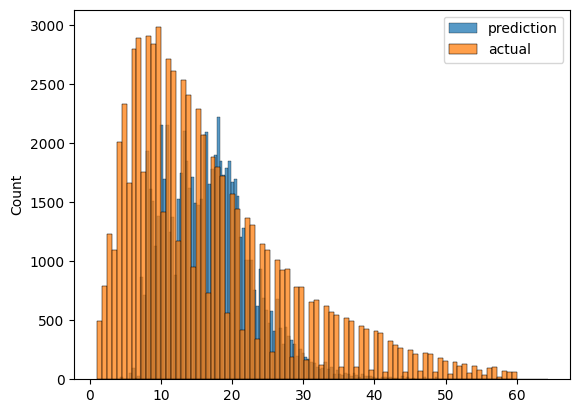

In [12]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

In [20]:
# Evaluating the model
categorical = ['PULocationID', 'DOLocationID']

def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [21]:
df_train = read_dataframe('../data/green/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green/green_tripdata_2021-02.parquet')

len(df_train), len(df_val)

(73908, 61921)

In [22]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [23]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206735978

In [29]:
with mlflow.start_run():

    mlflow.set_tag("developer", "anton")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [33]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [34]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [35]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
    ERROR
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:8.70560                           
[1]	validation-rmse:7.34155                           
[2]	validation-rmse:6.84986                           
[3]	validation-rmse:6.67060                           
[4]	validation-rmse:6.59047                           
[5]	validation-rmse:6.54933                           
[6]	validation-rmse:6.52760                           
[7]	validation-rmse:6.51283                           
[8]	validation-rmse:6.50165                           
[9]	validation-rmse:6.49543                           
[10]	validation-rmse:6.49103                          
[11]	validation-rmse:6.48669                          
[12]	validation-rmse:6.48263                          
[13]	validation-rmse:6.47838                          
[14]	validation-rmse:6.47640                          
[15]	validation-rmse:6.47328                          
[16]	validation-rmse:6.47112                          
[17]	validation-rmse:6.46463                          
[18]	valid

In [37]:
# Disable XGBoost's autologging feature in MLflow for manual control
mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    
    # Create DMatrix objects for training and validation datasets
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    # Parameters for the XGBoost model, obtained via hyperparameter tuning
    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }
    
    # Log these hyperparameters to MLflow
    mlflow.log_params(best_params)

    # Train the XGBoost model with early stopping
    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    # Make predictions on the validation set
    y_pred = booster.predict(valid)

    # Calculate the Root Mean Square Error (RMSE) for the predictions
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    # Log the RMSE metric to MLflow
    mlflow.log_metric("rmse", rmse)

    # Serialize the DataVectorizer object 'dv' using pickle
     with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
        
    # Log the pickled DataVectorizer object to MLflow
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    # Log the trained XGBoost model to MLflow
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


[0]	validation-rmse:11.44482
[1]	validation-rmse:10.77202
[2]	validation-rmse:10.18363
[3]	validation-rmse:9.67396
[4]	validation-rmse:9.23166
[5]	validation-rmse:8.84808
[6]	validation-rmse:8.51883
[7]	validation-rmse:8.23597
[8]	validation-rmse:7.99320
[9]	validation-rmse:7.78709
[10]	validation-rmse:7.61022
[11]	validation-rmse:7.45952
[12]	validation-rmse:7.33049
[13]	validation-rmse:7.22098
[14]	validation-rmse:7.12713
[15]	validation-rmse:7.04752
[16]	validation-rmse:6.98005
[17]	validation-rmse:6.92232
[18]	validation-rmse:6.87112
[19]	validation-rmse:6.82740
[20]	validation-rmse:6.78995
[21]	validation-rmse:6.75792
[22]	validation-rmse:6.72994
[23]	validation-rmse:6.70547
[24]	validation-rmse:6.68390
[25]	validation-rmse:6.66421
[26]	validation-rmse:6.64806
[27]	validation-rmse:6.63280
[28]	validation-rmse:6.61924
[29]	validation-rmse:6.60773
[30]	validation-rmse:6.59777
[31]	validation-rmse:6.58875
[32]	validation-rmse:6.58107
[33]	validation-rmse:6.57217
[34]	validation-rmse: